In [3]:
import os
import dmd
os.environ["OMP_NUM_THREADS"]='4'
import matplotlib.pyplot as plt
import numpy as np
import timeit
from scipy.linalg import pinv
colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

In [4]:
# N=10000
# K=2
# seed=1
# c=1
# t1=100
# dt=1E-2
# atol=1E-10
# fs=np.zeros(N+2)
# ns=[0,1,-1]
# omega=np.zeros(N)

# filebase='data/dmd1'
# os.system('mkdir -p %s'%(filebase))
# for n in np.arange(len(ns)):
#     os.system('rm %s/%i*'%(filebase,n))
#     fs[np.argsort(-omega)]=ns[n]*(2*np.pi*np.arange(N)/N-np.pi)
#     fs[-2]=-1E-14
#     fs[-1]=0.01
#     fs.tofile('%s/%ifs.dat'%(filebase,n))
#     os.system('bash -c "./kuramoto_64 -N %i -K %i -c %f -t %f -d %f -s %i -a %e -g 3 -nvR %s/%i"'%(N,K,c,t1,dt,seed,atol,filebase,n))
#     omega=np.fromfile('%s/0frequencies.dat'%(filebase),dtype=np.float64)

# K=2
# c=1.75
# filebase='data/dmd2'
# os.system('mkdir -p %s'%(filebase))
# for n in np.arange(len(ns)):
#     os.system('rm %s/%i*'%(filebase,n))
#     fs[np.argsort(-omega)]=ns[n]*(2*np.pi*np.arange(N)/N-np.pi)
#     fs[-2]=-1E-14
#     fs[-1]=0.01
#     fs.tofile('%s/%ifs.dat'%(filebase,n))
#     os.system('bash -c "./kuramoto_64 -N %i -K %i -c %f -t %f -d %f -s %i -a %e -g 3 -nvR %s/%i"'%(N,K,c,t1,dt,seed,atol,filebase,n))
#     omega=np.fromfile('%s/0frequencies.dat'%(filebase),dtype=np.float64)

# K=N
# c=1.75
# filebase='data/dmd3'
# os.system('mkdir -p %s'%(filebase))
# for n in np.arange(len(ns)):
#     os.system('rm %s/%i*'%(filebase,n))
#     fs[np.argsort(-omega)]=ns[n]*(2*np.pi*np.arange(N)/N-np.pi)
#     fs[-2]=-1E-14
#     fs[-1]=0.01
#     fs.tofile('%s/%ifs.dat'%(filebase,n))
#     os.system('bash -c "./kuramoto_64 -N %i -K %i -c %f -t %f -d %f -s %i -a %e -g 3 -nvR %s/%i"'%(N,K,c,t1,dt,seed,atol,filebase,n))
#     omega=np.fromfile('%s/0frequencies.dat'%(filebase),dtype=np.float64)

In [5]:
# os.system('./dmd.py --filebase data/dmd1/ > dmd1.out &')
# os.system('./dmd.py --filebase data/dmd2/ > dmd2.out &')
# os.system('./dmd.py --filebase data/dmd3/ > dmd3.out &')

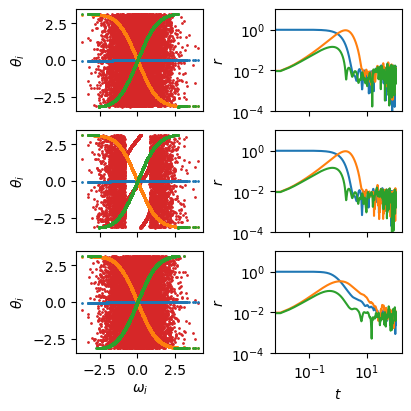

In [6]:
filebases=['data/dmd1/','data/dmd2/','data/dmd3/']
fig,axs=plt.subplots(3,2,figsize=(4,4) ,constrained_layout=True)

numtraj=3

for m in range(len(filebases)):
    n0s=np.concatenate([[0],np.cumsum(np.load('%s/n0s.npy'%(filebases[m]))-1)])

    for n in range(numtraj):
        filebase='%s/%i'%(filebases[m],n)
        file=open(filebase+'.out')
        lines=file.readlines()
        N,K,t1,dt,c,seed=np.array(lines[0].split(),dtype=np.float64)
        N=int(N)
        K=int(K)
        file.close()

    
        omega=np.fromfile(filebase+'frequencies.dat',dtype=np.float64)
        N=len(omega)
        thetas=np.fromfile(filebase+'thetas.dat',dtype=np.float64).reshape((-1,N))
        thetas=thetas-np.mean(omega)*dt*np.arange(thetas.shape[0])[:,np.newaxis]
        orders=np.fromfile(filebase+'order.dat',dtype=np.float64)
    
        plt.subplot(3,2,2+2*m)
        plt.plot(np.arange(len(orders))*dt,orders,c=colors[n],zorder=-5)
        plt.gca().set_rasterization_zorder(0)
        plt.xscale('log')
        plt.yscale('log')
        plt.ylabel('$r$')
        plt.ylim(1E-4,1E1)
        if m<2:
            plt.gca().set_xticklabels([])
        else:
            plt.xlabel('$t$')

        
        plt.subplot(3,2,1+2*m)
        plt.scatter(omega,np.mod(thetas[0]+np.pi,2*np.pi)-np.pi,s=1,zorder=-5)
        plt.gca().set_rasterization_zorder(0)
        plt.ylabel(r'$\theta_i$')
        
        if m<2:
            plt.gca().set_xticklabels([])
        else:
            plt.xlabel('$\omega_i$')
    plt.subplot(3,2,1+2*m)
    plt.scatter(omega,np.mod(thetas[-1]+np.pi,2*np.pi)-np.pi,s=1,zorder=-6)        
    

# plt.savefig('oscillatordmd1.pdf',dpi=200)
plt.show()

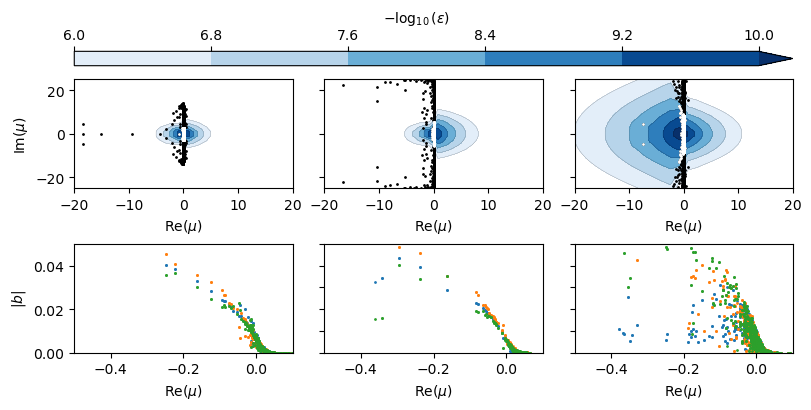

In [15]:
filebases=['data/dmd1/','data/dmd2/','data/dmd3/']
rescrit=1E-6

l=0
fig,axs=plt.subplots(2,3,figsize=(8,4),layout='constrained')

for m in range(len(filebases)):
    filebase0=filebases[m]
    n0s=np.concatenate([[0],np.cumsum(np.load('%s/n0s.npy'%(filebases[m]))-1)])
    
    filebase='%s%i'%(filebase0,0)
    file=open(filebase+'.out')
    lines=file.readlines()
    N,K,t1,dt,c,seed=np.array(lines[0].split(),dtype=np.float64)
    N=int(N)
    
    bs=np.load(filebase0+'bs.npy')
    evals=np.load(filebase0+'evals.npy')
    res=np.load(filebase0+'res.npy')
    inds=np.where(res<rescrit)[0]
    xs=np.real(np.log(evals)/dt)
    
    plt.subplot(2,3,4+l)

    # plt.scatter(xs,np.abs(bs[0]),c='grey',s=2)
    for n in range(numtraj):
        plt.scatter(xs[inds],np.abs(bs[n0s[n]])[inds],c=colors[n],s=1,zorder=-5)
    plt.gca().set_rasterization_zorder(0)

    plt.xlabel(r'$\mathrm{Re}(\mu)$')
    plt.xlim(-0.5,0.1)
    plt.ylim(0,0.05)
    if l>0:
        plt.gca().set_yticks(plt.gca().get_yticks(),['']*len(plt.gca().get_yticks()))
    else:
        plt.ylabel(r'$|b|$')
    plt.ylim(0,0.05)

    pseudo1=np.load('%s/pseudo.npy'%(filebase0))
    zs1=np.load('%s/zs.npy'%(filebase0))
    evals1=np.load('%s/evals.npy'%(filebase0))
    res1=np.load('%s/res.npy'%(filebase0))
    nr=26
    ni=26
    
    resmin=1E-6
    resmax=1E-10
    rescrit=1E-8
    levels=-np.log(resmin)/np.log(10)+(-np.log(resmax)/np.log(10)+np.log(resmin)/np.log(10))*np.arange(6)/5

    plt.subplot(2,3,1+l)
    cs1 = plt.gca().tricontourf(np.real(np.log(zs1)/dt),np.imag(np.log(zs1)/dt),np.log(1/np.array(pseudo1))/np.log(10),levels=levels,cmap='Blues',extend='max',zorder=-5)
    cs2 = plt.gca().tricontour(cs1,levels=levels,colors=('k',),linewidths=0.1,zorder=-5)

    plt.gca().set_rasterization_zorder(0)
    
    xs1=np.real(np.log(evals1)/dt)
    ys1=np.imag(np.log(evals1)/dt)

    inds=np.where(res1<rescrit)[0]
    plt.scatter(xs1,ys1,c='black',s=1,zorder=-5)
    plt.scatter(xs1[inds],ys1[inds],c='white',s=1,zorder=-5)
    # plt.ylim(-3,3)
    # plt.xlim(-0.6,0.6)
    plt.xlim(np.min(np.real(np.log(zs1)/dt)),np.max(np.real(np.log(zs1)/dt)))
    plt.ylim(np.min(np.imag(np.log(zs1)/dt)),np.max(np.imag(np.log(zs1)/dt)))            
    if l>0:
        plt.gca().set_yticklabels([])
    else:
        plt.ylabel('$\mathrm{Im}({\mu})$')
    plt.xlabel('$\mathrm{Re}({\mu})$')

    l=l+1

fig.colorbar(cs1, ax=axs[:,:], location='top',aspect=50,label=r'$-\log_{10}(\varepsilon)$')

plt.savefig('oscillatordmd2.pdf',dpi=200)
plt.show()

In [8]:
filebases=['data/dmd1/','data/dmd2/','data/dmd3/']
X_reconstructs=[]
for filebase0 in filebases:
    phis=np.load('%s/phis.npy'%(filebase0))
    bs=np.load('%s/bs.npy'%(filebase0))
    evals=np.load('%s/evals.npy'%(filebase0))
    res=np.load('%s/res.npy'%(filebase0))
    n0s=np.concatenate([[0],np.cumsum(np.load('%s/n0s.npy'%(filebase0))-1)])
    
    inds=np.where(res<1E-6)[0]
    X_reconstruct=np.zeros((bs.shape[0],phis.shape[0]))
    for n in range(numtraj):
        print(filebase0,n)
        n0=n0s[n]
        X_reconstruct[n0:n0s[n+1]]=np.real((bs[n0,inds]*np.linalg.pinv(phis)[inds].T).dot(evals[inds,np.newaxis]**np.arange(n0s[n+1]-n0s[n])[np.newaxis,:])).T
    X_reconstructs=X_reconstructs+[X_reconstruct]

data/dmd1/ 0
data/dmd1/ 1
data/dmd1/ 2
data/dmd2/ 0
data/dmd2/ 1
data/dmd2/ 2
data/dmd3/ 0
data/dmd3/ 1
data/dmd3/ 2


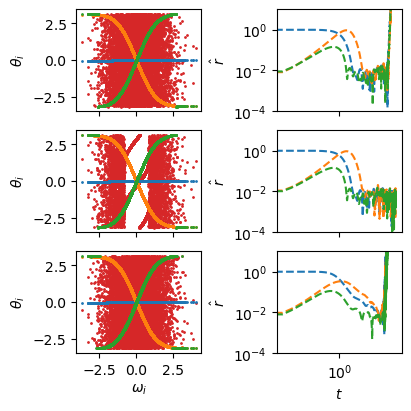

In [9]:
filebases=['data/dmd4_1/','data/dmd5_1/','data/dmd6_1/']
fig,axs=plt.subplots(3,2,figsize=(4,4) ,constrained_layout=True)

numtraj=3

for m in range(len(filebases)):
    n0s=np.concatenate([[0],np.cumsum(np.load('%s/n0s.npy'%(filebases[m]))-1)])

    for n in range(numtraj):
        filebase='%s/%i'%(filebases[m],n)
        file=open(filebase+'.out')
        lines=file.readlines()
        N,K,t1,dt,c,seed=np.array(lines[0].split(),dtype=np.float64)
        N=int(N)
        K=int(K)
        file.close()
        X_reconstruct=X_reconstructs[m]

    
        omega=np.fromfile(filebase+'frequencies.dat',dtype=np.float64)
        N=len(omega)
        thetas=np.fromfile(filebase+'thetas.dat',dtype=np.float64).reshape((-1,N))
        thetas=thetas-np.mean(omega)*dt*np.arange(thetas.shape[0])[:,np.newaxis]
        orders=np.fromfile(filebase+'order.dat',dtype=np.float64)
    
        plt.subplot(3,2,2+2*m)
        # plt.plot(dt*np.arange(orders.shape[0]),orders)
        # plt.plot(np.arange(len(orders))*dt,orders,c=colors[n],zorder=-5)
        plt.plot(np.arange(n0s[n+1]-n0s[n])*dt,np.abs(np.mean(X_reconstruct[n0s[n]:n0s[n+1],:N]+1j*X_reconstruct[n0s[n]:n0s[n+1],N:],axis=1)),ls='--',c=colors[n],zorder=-5)
        plt.gca().set_rasterization_zorder(0)
        plt.xscale('log')
        plt.yscale('log')
        plt.ylabel('$\hat{r}$')
        plt.ylim(1E-4,1E1)
        if m<2:
            plt.gca().set_xticklabels([])
        else:
            plt.xlabel('$t$')

        
        plt.subplot(3,2,1+2*m)
        plt.scatter(omega,np.mod(thetas[0]+np.pi,2*np.pi)-np.pi,s=1,zorder=-5)
        plt.gca().set_rasterization_zorder(0)
        plt.ylabel(r'$\theta_i$')
        
        if m<2:
            plt.gca().set_xticklabels([])
        else:
            plt.xlabel('$\omega_i$')
    plt.subplot(3,2,1+2*m)
    plt.scatter(omega,np.mod(thetas[-1]+np.pi,2*np.pi)-np.pi,s=1,zorder=-6)        
    

plt.show()

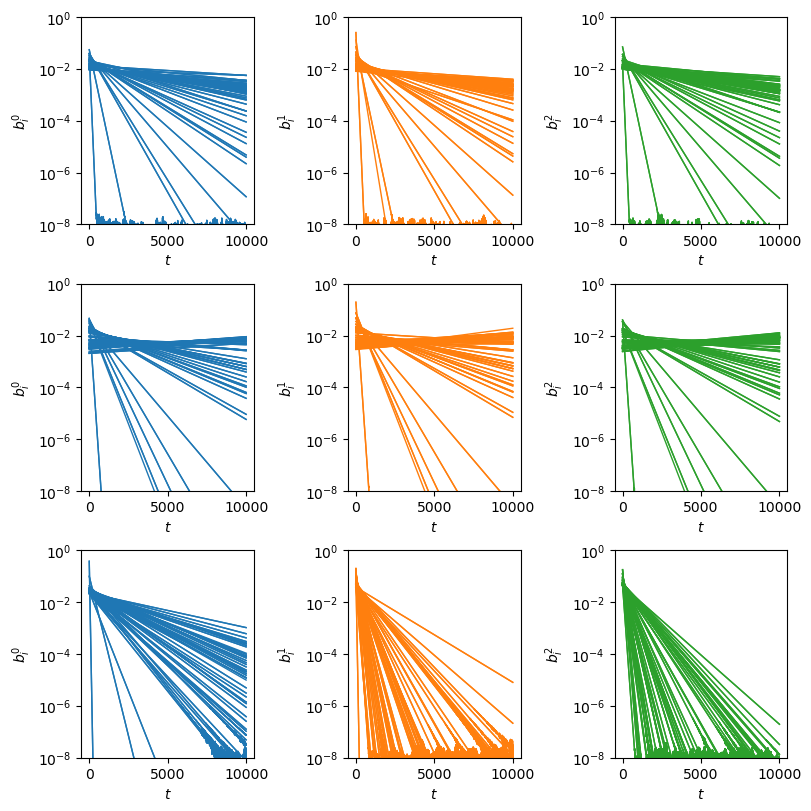

In [10]:
plt.subplots(3,3,figsize=(8,8),layout='constrained')

l=1
for m in range(len(filebases)):
    filebase0=filebases[m]
    bs=np.load('%s/bs.npy'%(filebase0))
    evals=np.load('%s/evals.npy'%(filebase0))
    res=np.load('%s/res.npy'%(filebase0))
    n0s=np.concatenate([[0],np.cumsum(np.load('%s/n0s.npy'%(filebase0))-1)])
    inds=np.where(res<1E-6)[0]
    for n in range(numtraj):
        plt.subplot(3,3,l)
        inds2=np.argsort(np.abs(bs[n0s[n],inds]))
        plt.plot(np.abs(bs[n0s[n]:n0s[n+1],inds[inds2[-100:]]]),c=colors[n],lw=1)
        plt.xlabel('$t$')
        plt.ylabel('$b_i^%i$'%(n))
        plt.yscale('log')
        plt.ylim(1E-8,1E0)
        l=l+1
